In [1]:
import mxnet as mx
import mxnet.ndarray as nd
from mxnet import autograd
import numpy as np

In [2]:
ctx = mx.gpu()
mx.random.seed(1)

In [3]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

In [4]:
mnist = mx.test_utils.get_mnist()
num_examples = 1000
batch_size = 64
train_data = mx.gluon.data.DataLoader(
    mx.gluon.data.ArrayDataset(mnist["train_data"][:num_examples],
        mnist["train_label"][:num_examples].astype(np.float32)),
        batch_size, shuffle=True)
test_data = mx.gluon.data.DataLoader(
    mx.gluon.data.ArrayDataset(mnist["test_data"][:num_examples],
        mnist["test_label"][:num_examples].astype(np.float32)),
        batch_size, shuffle=False)

In [24]:
W = nd.random_normal(shape=(784, 10))
b = nd.random_normal(shape=10)
W = W.as_in_context(ctx)
b = b.as_in_context(ctx)

params = [W, b]

for param in params:
    param.attach_grad()
    
def net(X):
    y_linear = nd.dot(X, W) + b
    y_hat = nd.softmax(y_linear, axis=1)
    return y_hat

In [25]:
def cross_entropy(y_hat, y):
    return - nd.sum(y * nd.log(y_hat), axis=0, exclude=True)

def SGD(params, lr):
    for param in params:
        param[:] = param - lr * param.grad

In [26]:
def evaluate_accuracy(data_iterator, net):
    numerator = 0.
    denominator = 0.
    loss_avg = 0.
    for i, (data, label) in enumerate(data_iterator):
        data = data.as_in_context(ctx).reshape((-1,784))
        label = label.as_in_context(ctx)
        label_one_hot = nd.one_hot(label, 10)
        output = net(data)
        loss = cross_entropy(output, label_one_hot)
        predictions = nd.argmax(output, axis=1)
        numerator += nd.sum(predictions == label)
        denominator += data.shape[0]
        loss_avg = loss_avg*i/(i+1) + nd.mean(loss).asscalar()/(i+1)
    return (numerator / denominator).asscalar(), loss_avg

In [27]:
def plot_learningcurves(loss_tr, loss_ts, acc_tr, acc_ts):
    xs = list(range(len(loss_tr)))
    
    f = plt.figure(figsize=(12, 6))
    fg1 = f.add_subplot(121)
    fg2 = f.add_subplot(122)
    
    fg1.set_xlabel("epoch", fontsize=14)
    fg1.set_title("Comparing loss functions")
    fg1.semilogy(xs, loss_tr)
    fg1.semilogy(xs, loss_ts)
    fg1.grid(True, which="both")
    fg1.legend(['training loss', 'testing loss'], fontsize=14)
    
    fg2.set_title('Comparing accuracy')
    fg1.set_xlabel('epoch',fontsize=14)
    fg2.plot(xs, acc_tr)
    fg2.plot(xs, acc_ts)
    fg2.grid(True,which="both")
    fg2.legend(['training accuracy', 'testing accuracy'], fontsize=14)

Completed epoch 100. Train Loss: 0.493218569085, Test Loss 1.44212992489, Train_acc 0.89, Test_acc 0.704
Completed epoch 200. Train Loss: 0.227533431258, Test Loss 1.27099385858, Train_acc 0.958, Test_acc 0.729
Completed epoch 300. Train Loss: 0.131176914088, Test Loss 1.21520712972, Train_acc 0.974, Test_acc 0.74
Completed epoch 400. Train Loss: 0.0819587702863, Test Loss 1.1850660257, Train_acc 0.989, Test_acc 0.746
Completed epoch 500. Train Loss: 0.0539330674801, Test Loss 1.16768796369, Train_acc 0.996, Test_acc 0.757
Completed epoch 600. Train Loss: 0.0398483007448, Test Loss 1.1561536938, Train_acc 0.999, Test_acc 0.759
Completed epoch 700. Train Loss: 0.0312213023426, Test Loss 1.14654841647, Train_acc 1.0, Test_acc 0.761
Completed epoch 800. Train Loss: 0.0253794399323, Test Loss 1.139177531, Train_acc 1.0, Test_acc 0.763
Completed epoch 900. Train Loss: 0.0217395906802, Test Loss 1.13346815482, Train_acc 1.0, Test_acc 0.768
Completed epoch 1000. Train Loss: 0.0190815619426, T

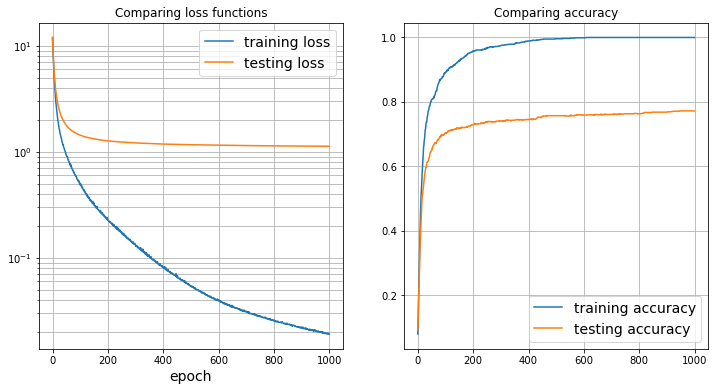

In [28]:
epochs = 1000
moving_loss = 0.
niter=0

loss_seq_train = []
loss_seq_test = []
acc_seq_train = []
acc_seq_test = []


for e in range(epochs):
    for i, (data, label) in enumerate(train_data):
        data = data.as_in_context(ctx).reshape((-1,784))
        label = label.as_in_context(ctx)
        label_one_hot = nd.one_hot(label, 10)
        with autograd.record():
            output = net(data)
            loss = cross_entropy(output, label_one_hot)
        loss.backward()
        SGD(params, .001)

        ##########################
        #  Keep a moving average of the losses
        ##########################
        niter +=1
        moving_loss = .99 * moving_loss + .01 * nd.mean(loss).asscalar()
        est_loss = moving_loss/(1-0.99**niter)

    test_accuracy, test_loss = evaluate_accuracy(test_data, net)
    train_accuracy, train_loss = evaluate_accuracy(train_data, net)

    # save them for later
    loss_seq_train.append(train_loss)
    loss_seq_test.append(test_loss)
    acc_seq_train.append(train_accuracy)
    acc_seq_test.append(test_accuracy)


    if e % 100 == 99:
        print("Completed epoch %s. Train Loss: %s, Test Loss %s, Train_acc %s, Test_acc %s" %
              (e+1, train_loss, test_loss, train_accuracy, test_accuracy))


## Plotting the learning curves
plot_learningcurves(loss_seq_train,loss_seq_test,acc_seq_train,acc_seq_test)

In [29]:
def l2_penalty(params):
    penalty = nd.zeros(shape=1)
    penalty = penalty.as_in_context(ctx)
    for param in params:
        penalty = penalty + nd.sum(param ** 2)
        return penalty

In [30]:
for param in params:
    param[:] = nd.random_normal(shape=param.shape)

In [31]:
epochs = 1000
moving_loss = 0.
l2_strength = .1
niter=0

loss_seq_train = []
loss_seq_test = []
acc_seq_train = []
acc_seq_test = []


for e in range(epochs):
    for i, (data, label) in enumerate(train_data):
        data = data.as_in_context(ctx).reshape((-1,784))
        label = label.as_in_context(ctx)
        label_one_hot = nd.one_hot(label, 10)
        with autograd.record():
            output = net(data)
            loss = nd.sum(cross_entropy(output, label_one_hot)) + l2_strength * l2_penalty(params)
        loss.backward()
        SGD(params, .001)

        ##########################
        #  Keep a moving average of the losses
        ##########################
        niter +=1
        moving_loss = .99 * moving_loss + .01 * nd.mean(loss).asscalar()
        est_loss = moving_loss/(1-0.99**niter)


    test_accuracy, test_loss = evaluate_accuracy(test_data, net)
    train_accuracy, train_loss = evaluate_accuracy(train_data, net)

    # save them for later
    loss_seq_train.append(train_loss)
    loss_seq_test.append(test_loss)
    acc_seq_train.append(train_accuracy)
    acc_seq_test.append(test_accuracy)

    if e % 100 == 99:
        print("Completed epoch %s. Train Loss: %s, Test Loss %s, Train_acc %s, Test_acc %s" %
              (e+1, train_loss, test_loss, train_accuracy, test_accuracy))

Completed epoch 100. Train Loss: 0.38153540995, Test Loss 1.15425642207, Train_acc 0.892, Test_acc 0.717
Completed epoch 200. Train Loss: 0.188725554384, Test Loss 0.805607581511, Train_acc 0.966, Test_acc 0.769
Completed epoch 300. Train Loss: 0.141792318318, Test Loss 0.662871800363, Train_acc 0.985, Test_acc 0.787
Completed epoch 400. Train Loss: 0.131049188785, Test Loss 0.587457111105, Train_acc 0.991, Test_acc 0.803
Completed epoch 500. Train Loss: 0.127413894515, Test Loss 0.545308243483, Train_acc 0.993, Test_acc 0.814
Completed epoch 600. Train Loss: 0.127126353327, Test Loss 0.52313391678, Train_acc 0.993, Test_acc 0.821
Completed epoch 700. Train Loss: 0.126942903735, Test Loss 0.510197125375, Train_acc 0.992, Test_acc 0.828
Completed epoch 800. Train Loss: 0.127379112411, Test Loss 0.502014454454, Train_acc 0.993, Test_acc 0.831
Completed epoch 900. Train Loss: 0.128119588364, Test Loss 0.497514149174, Train_acc 0.994, Test_acc 0.836
Completed epoch 1000. Train Loss: 0.1278